In [1]:
import medleydb as mdb
import librosa
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import librosa.display
import pandas as pd
import IPython.display as ipd
import os
import random
from os import path
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer

%load_ext line_profiler

HOME_PATH = path.expanduser("~")
UNSEEN_PATH = os.path.join(HOME_PATH, "data", "es_data",)
DATA_PATH = path.join(HOME_PATH, "data", "preprocessed")
MIX_PATH = path.join(HOME_PATH, "data", "medleydb", "medleydb", "Audio")
CACHE_PATH = path.join(HOME_PATH, "data", "cache")

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

# Ändra till detta i en paketstruktur
# DATA_PATH = path.join(path.dirname(__file__), 'data', 'preprocessed')

# Based off of OpenMICs taxonomy discussions and the MedleyDB taxonomy yaml
OPENMIC_TO_MEDLEY = {
    "drums": [
        "drum set",
        "drum machine",
        "kick drum",
        "cymbal",
        "conga",
        "snare drum",
        "bass drum",
        "high hat",
        "bongo",
    ],
    "bass": ["electric bass", "double bass"],
    "guitar": [
        "distorted electric guitar",
        "clean electric guitar",
        "acoustic guitar",
        "lap steel guitar",
    ],
    "voice": [
        "male singer",
        "female singer",
        "male speaker",
        "female speaker",
        "male rapper",
        "female rapper",
        "beatboxing",
        "vocalists",
        "choir",
        "male screamer",
        "female screamer",
    ],
    "piano": ["piano", "tack piano", "electric piano"],
}

others = mdb.get_valid_instrument_labels()
for k, v in OPENMIC_TO_MEDLEY.items():
    for i in v:
        others.remove(i)
others = list(others)

OPENMIC_TO_MEDLEY["other"] = others

print(OPENMIC_TO_MEDLEY)

INSTRUMENTS = OPENMIC_TO_MEDLEY.keys()
INSTRUMENT_INDEX = {key: i for i, (key, _) in enumerate(OPENMIC_TO_MEDLEY.items())}
MEDLEY_TO_OPENMIC = {v: k for k, v_list in OPENMIC_TO_MEDLEY.items() for v in v_list}
MEDLEY_TO_INDEX = {k: INSTRUMENT_INDEX[v] for k, v in MEDLEY_TO_OPENMIC.items()}
REV_INSTRUMENT_INDEX = {v: k for k, v in INSTRUMENT_INDEX.items()}
NUM_LABELS = len(INSTRUMENTS)


def play_medley_audio(track):
    track_id = load_track(track).mix_path
    samples, sample_rate = librosa.load(track_id)
    ipd.display(ipd.Audio(samples, rate=sample_rate))


def play_audio(track):
    homedir = os.path.expanduser("~")
    path = os.path.join(homedir, "data/es_data", track)
    samples, sample_rate = librosa.load(path)
    ipd.display(ipd.Audio(samples, rate=sample_rate))


def play_audio_from_waveform(track, sr):
    ipd.display(ipd.Audio(track, rate=sr))


def load_track(track_id):
    t_gen = mdb.load_multitracks([track_id])
    return next(t_gen)

/home/carlnys/data/medleydb/medleydb/__init__.py:68: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  INST_TAXONOMY = yaml.load(fhandle)
/home/carlnys/data/medleydb/medleydb/__init__.py:76: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  MIXING_COEFFICIENTS = yaml.load(fhandle)


{'drums': ['drum set', 'drum machine', 'kick drum', 'cymbal', 'conga', 'snare drum', 'bass drum', 'high hat', 'bongo'], 'bass': ['electric bass', 'double bass'], 'guitar': ['distorted electric guitar', 'clean electric guitar', 'acoustic guitar', 'lap steel guitar'], 'voice': ['male singer', 'female singer', 'male speaker', 'female speaker', 'male rapper', 'female rapper', 'beatboxing', 'vocalists', 'choir', 'male screamer', 'female screamer'], 'piano': ['piano', 'tack piano', 'electric piano'], 'other': ['recorder', 'cello', 'castanet', 'clarinet section', 'tabla', 'harmonica', 'cowbell', 'violin section', 'violin', 'auxiliary percussion', 'gu', 'fx/processed sound', 'oud', 'bandoneon', 'whistle', 'cello section', 'horn section', 'bagpipe', 'french horn section', 'bamboo flute', 'timpani', 'cabasa', 'electronic organ', 'theremin', 'claps', 'tambourine', 'scratches', 'harp', 'flute section', 'melodica', 'string section', 'cornet', 'tenor saxophone', 'shaker', 'viola section', 'soprano s

In [2]:
def create_train_val_test_split(tracks, test_size=0.2, val_size=0.2):
    X = []
    Y = []

    for t in tracks:
        instruments = {
            MEDLEY_TO_OPENMIC[i]
            for i in t.stem_instruments
            if i in MEDLEY_TO_OPENMIC.keys()
        }
        #
        # intersection = instruments.intersection(INSTRUMENTS)
        #
        # if "other" in intersection and len(intersection) < 3:
        #    continue
        # elif len(intersection) < 2:
        #    continue
        #
        X.append(t)
        Y.append(list(instruments))

    mlb = MultiLabelBinarizer(list(INSTRUMENTS))
    Y = mlb.fit_transform(Y)
    X = np.array(X)

    test_train = MultilabelStratifiedShuffleSplit(
        n_splits=2, test_size=test_size, random_state=0
    )

    for train_index, test_index in test_train.split(X, Y):
        X_train, test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        break

    train_val = MultilabelStratifiedShuffleSplit(
        n_splits=2, test_size=val_size, random_state=0
    )

    for train_index, test_index in train_val.split(X_train, Y_train):
        train, val = X_train[train_index], X_train[test_index]
        train_labels, val_labels = Y_train[train_index], Y_train[test_index]
        break

    print("Training sample length:", train.shape[0])
    print("Distribution:", np.sum(train_labels, axis=0))
    print("Validation sample length:", val.shape[0])
    print("Distribution:", np.sum(val_labels, axis=0))
    print("Test sample length", test.shape[0])
    print("Distribution:", np.sum(Y_test, axis=0))

    return train, val, test


# Example {"guitar": [stem_1.wav, ..., stem_n.wav], "bass": [stem_1.wav, ..., stem_n.wav]...}
def mdb_index(tracklist):
    files = {k: [] for k, v in OPENMIC_TO_MEDLEY.items()}
    for t in tracklist:
        for k, v in t.stems.items():
            if v.instrument[0] in MEDLEY_TO_OPENMIC.keys():
                instrument = MEDLEY_TO_OPENMIC[v.instrument[0]]
                files[instrument].append(v.audio_path)
    return files


# Example {"ArtistSong" : {"guitar" : [stem_1.wav, stem_2.wav]} }
def mdb_baseline_index(tracklist):
    files = {}
    for t in tracklist:
        for k, v in t.stems.items():
            # help(v)
            if v.instrument[0] in MEDLEY_TO_OPENMIC.keys():
                instrument = MEDLEY_TO_OPENMIC[v.instrument[0]]
                if t.track_id not in files.keys():
                    files[t.track_id] = {k: [] for k, _ in OPENMIC_TO_MEDLEY.items()}
                files[t.track_id][instrument] = files[t.track_id].get(
                    instrument, []
                ) + [v.audio_path]
    return files

In [19]:
from joblib import Memory

# Creates a cache for function calls with certain parameters and their returns
memory = Memory(CACHE_PATH, verbose=0)
load = memory.cache(librosa.load)
get_duration = memory.cache(librosa.get_duration)


def x_y_from_stem(f, s_p, offset):
    num_windows = s_p["num_windows"]
    duration = s_p["duration"]
    spectrogram_len = s_p["spectrogram_len"]
    n_fft = s_p["n_fft"]
    hop_length = s_p["hop_length"]
    n_mels = s_p["n_mels"]
    sr = s_p["sample_rate"]

    if offset is None:
        d = get_duration(filename=f)
        offset = random.randint(0, int(d - duration))

    # Loading and caching the whole stem for less cache misses
    # (MUCH faster than loading and caching snippets)
    waveform, _ = load(f, sr, res_type="kaiser_fast",)

    # Convert offset to samples
    waveform = waveform[sr * offset : sr * offset + int(sr * duration)]

    y = librosa.feature.rms(waveform) > 0.01
    # x = librosa.feature.melspectrogram(
    #    waveform, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    # )
    # x = librosa.power_to_db(x, ref=np.max).astype(np.float32)
    return waveform, y, offset


def mix(files, s_p, baseline):
    while True:
        xs = []
        ys = []
        paths = {k: [] for k, v in OPENMIC_TO_MEDLEY.items()}

        # reformat input to {'guitar' : [stem_1.wav,...], 'bass': [stem_2.wav,...]}
        if baseline:
            song_id, instrument_dict = random.choice(list(files.items()))
            d = None
            for instrument, stems in instrument_dict.items():
                for stem in stems:
                    paths[instrument].append(stem)
        else:
            for instrument, stems in files.items():
                paths[instrument].append(random.choice(stems))

        offset = None
        # invariant to input type
        for _, path_list in paths.items():
            y = np.zeros((1, s_p["num_windows"]))
            if not baseline:
                offset = None
            for path in path_list:
                x, _y, offset = x_y_from_stem(path, spectrogram_params, offset)
                y = np.logical_or(y, _y)
                xs.append(x)
            ys.append(y)

        x = np.sum(np.array(xs), axis=0)
        x = librosa.feature.melspectrogram(
            x,
            sr=s_p["sample_rate"],
            n_fft=s_p["n_fft"],
            hop_length=s_p["hop_length"],
            n_mels=s_p["n_mels"],
        )
        x = librosa.power_to_db(x, ref=np.max).astype(np.float32)
        x = np.expand_dims(x, axis=0)
        x -= x.min()
        # Sometimes complete silence and division by 0 
        if x.max() != 0:
            x /= x.max()
        y = np.stack(ys)
        y = y.reshape(y.shape[0], y.shape[2])
        y = y.astype(float)
        yield x, y

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import medleydb as mdb
import librosa
import librosa.display
import IPython.display as ipd
import sklearn.metrics as metrics


class MedleyDB(Dataset):
    def __init__(self, files, spectrogram_params, baseline=False):
        self.files = files
        self.baseline = baseline
        self.spectrogram_params = spectrogram_params
        self.mixer = mix(self.files, self.spectrogram_params, self.baseline)

    def __getitem__(self, idx):
        return next(self.mixer)

    def __len__(self):
        length = 0
        if self.baseline:
            # for k, v in self.files.items():
            #    for instrument, stems in v.items():
            #        length += len(stems)

            # Just an arbitrary heuristic assuming each song is 120s long
            return int(len(self.files) * 120 // spectrogram_params["duration"])
        else:
            for k, v in self.files.items():
                length += len(v)
            # Assume each song consist of 4 stems, 120 seconds long
            return int((length // 4) * (120 // spectrogram_params["duration"]))


# Works fine, but have to rewrite training to account for notion of epochs
# class MedleyDB(torch.utils.data.IterableDataset):
#    def __init__(self, files, spectrogram_params, baseline=False):
#        self.files = files
#        self.baseline = baseline
#        self.spectrogram_params = spectrogram_params
#        self.mixer = mix(self.files, self.spectrogram_params, self.baseline)
#
#    def __iter__(self):
#        return iter(self.mixer)

In [4]:
def display_spectrogram(s, p):

    librosa.display.specshow(
        s, x_axis="time", y_axis="mel", sr=p["sample_rate"], hop_length=p["hop_length"]
    )
    plt.colorbar(format="%+2.0f dB")
    plt.title("Mel-frequency spectrogram")
    plt.tight_layout()
    plt.show()


def test_instrument_activations():
    y_tot = np.zeros((5, 256)).astype(float)
    gen = mix(train_paths, spectrogram_params, True)
    for i in range(1000):
        x, y = next(gen)
        y_tot += y

    y_tot = y_tot.sum(axis=1)
    return y_tot


def test_data_loader(data_loader):
    x, y = next(iter(data_loader))
    s = x.numpy()[0]
    s1 = x.numpy()[1]
    comparison = s1 == s
    equal_arrays = comparison.all()
    print(equal_arrays)
    print(s.shape)
    l = y.numpy()[0]
    l2 = y.numpy()[1]
    print(l2)
    print(l.shape)
    np.set_printoptions(threshold=sys.maxsize)
    print(len(l[0]))
    display_spectrogram(s[0], spectrogram_params)

In [5]:
# Trying to mimic TUT-SED Synthetic 2016 in
# Convolutional Recurrent Neural Networks for
# Polyphonic Sound Event Detection
class CRNN(nn.Module):
    def __init__(self, gru_input, gru_hidden, gru_layers, complx=False):
        super(CRNN, self).__init__()

        self.gru_input = gru_input
        self.gru_hidden = gru_hidden
        self.gru_layers = gru_layers

        # We only pool on the freq. axis
        self.pool_2x1 = nn.MaxPool2d([2, 1])
        self.pool_4x1 = nn.MaxPool2d([4, 1])

        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1
        )
        self.conv1_bn = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1
        )
        self.conv2_bn = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1
        )
        self.conv3_bn = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1
        )
        self.conv4_bn = nn.BatchNorm2d(256)

        # now stack -> [batch_size, 256, 1, 256] -> [batch_size, 256*1, 256]

        # (input shape (w.o batch), hidden shape, n_layers, batch_first=True)
        self.gru = nn.GRU(gru_input, gru_hidden, gru_layers, batch_first=True)
        # torch.Size([batch_size, 256, 1, 256])
        if complx:
            self.fc1 = nn.Linear(256, 1024)
            self.fc2 = nn.Linear(1024, 1024)
            self.fc3 = nn.Linear(1024, NUM_LABELS)
        else:
            self.fc = nn.Linear(256, NUM_LABELS)

    def forward(self, x, h):
        assert x.min() >= 0 and x.max() <= 1
        # print(x.shape)
        # add sequence of convolutional and max pooling layers
        x = F.relu(self.pool_4x1(self.conv1_bn(self.conv1(x))))
        # print(x.shape)
        x = F.relu(self.pool_4x1(self.conv2_bn(self.conv2(x))))
        # print(x.shape)
        x = F.relu(self.pool_4x1(self.conv3_bn(self.conv3(x))))
        # print(x.shape)
        x = F.relu(self.pool_2x1(self.conv4_bn(self.conv4(x))))
        # print("After CNN", x.shape)
        # torch.Size([batch_size, 256, 1, 256])
        # (batch x classes x 1 x time) -> (batch x classes x time)
        x = x.view(x.shape[0], 256, 256)
        # Gru expects (batch, seq, feature)
        # The sequence in this case is our time axis
        x = x.permute(0, 2, 1)
        # print("After permute", x.shape)
        x, h = self.gru(x, h)
        # print("After gru", x.shape)
        if complx:
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
        else:
            x = self.fc(x)
        # print("After fc,", x.shape)
        # (batch_size, seq, num_classes)
        x = x.permute(0, 2, 1)
        # print("After permute back", x.shape)
        return x, h

    def init_hidden(self, batch_size):
        """ Initializes hidden state """
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        # (n_layers, batch, n_hidden)
        h0 = Variable(torch.zeros(self.gru_layers, batch_size, self.gru_hidden)).cuda()
        return h0

In [6]:
def save_state(state, filename="state.pt"):
    torch.save(state, filename)


def train_model(model_name, crnn=False):
    validation_loss_min = sys.maxsize
    train_losses = []
    validation_losses = []
    for epoch in range(1, n_epochs + 1):
        if crnn:
            h = model.init_hidden(batch_size)
            val_h = model.init_hidden(batch_size)
        print("Epoch: {}/{}".format(epoch, n_epochs))
        # keep track of training and validation loss
        train_loss = 0.0
        validation_loss = 0.0
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train):
            print("Batch: {}/{}".format(batch_idx, num_batches), end="\r")
            # move tensors to GPU if CUDA is available
            if gpu_available:
                data, target = data.float().cuda(), target.float().cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            if crnn:
                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                h = model.init_hidden(data.shape[0])
                output, h = model(data, h)
            # forward pass: compute predicted outputs by passing inputs to the model
            # print(data.shape)
            else:
                output = model(data)
            # print(output.shape)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss, loss.item is the avarage loss of the batch.
            train_loss += loss.item() * data.size(0)

        ######################
        # validate the model #
        ######################
        model.eval()
        for data, target in validation:
            # move tensors to GPU if CUDA is available
            if gpu_available:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            if crnn:
                # Detatching hidden state from the computational graph
                # (see truncated back propagation through time) such that
                # the graph doesn't become super big, slowing down computations
                # and exploding the gradient.

                # Note however that the hidden state VALUE will still be inherited
                # We just say that it doesn't depend on previous hidden states
                val_h = model.init_hidden(data.shape[0])
                output, val_h = model(data, val_h)
            else:
                output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss
            validation_loss += loss.item() * data.size(0)

        # calculate average losses
        train_loss = train_loss / len(train.sampler)
        validation_loss = validation_loss / len(validation.sampler)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        # plot_loss(train_losses, validation_losses)
        # print training/validation statistics
        print(
            "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
                epoch, train_loss, validation_loss
            )
        )

        # save model if validation loss has decreased
        if validation_loss <= validation_loss_min:
            print(
                "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                    validation_loss_min, validation_loss
                )
            )

            state = {
                "model_name": model_name,
                "epoch": epoch + 1,
                "lr": lr,
                "train_losses": train_losses,
                "validation_losses": validation_losses,
                "state_dict": model.state_dict(),
                "best_val_acc": validation_loss,
                "optimizer": optimizer.state_dict(),
            }

            if crnn:
                save_state(state, "%s.pt" % model_name)

            else:
                save_state(state, "%s.pt" % model_name)

            validation_loss_min = validation_loss

    state = {
        "model_name": model_name,
        "epoch": epoch + 1,
        "lr": lr,
        "train_losses": train_losses,
        "validation_losses": validation_losses,
        "state_dict": model.state_dict(),
        "best_val_acc": validation_loss,
        "optimizer": optimizer.state_dict(),
    }

    if crnn:
        save_state(state, "overfit_%s.pt" % model_name)

    else:
        save_state(state, "overfit_%s.pt" % model_name)

In [7]:
from sklearn.metrics import classification_report


def calculate_metrics(scores, predictions, targets):
    cr = classification_report(
        targets, predictions, target_names=list(INSTRUMENTS), output_dict=False
    )

    print(cr)

    cr = classification_report(
        targets, predictions, target_names=list(INSTRUMENTS), output_dict=True
    )
    # f1_macro = metrics.f1_score(targets, predictions, average='macro')
    # f1_micro = metrics.f1_score(targets, predictions, average='micro')
    lrap = metrics.label_ranking_average_precision_score(targets, scores)
    auc_roc_micro = metrics.roc_auc_score(targets, scores, average="micro")
    auc_roc_macro = metrics.roc_auc_score(targets, scores, average="macro")
    print("lrap:", lrap)
    print("AUC-ROC-Macro:", auc_roc_macro)
    print("AUC-ROC-Micro:", auc_roc_micro)
    cr["lrap"] = lrap
    cr["auc_roc_macro"] = auc_roc_macro
    cr["auc_roc_micro"] = auc_roc_micro
    return cr


# REMEMBER TO MANUALLY SIGMOID THE OUTPUTS SINCE THE LOSS DOES THAT FOR US
def test_model(model, crnn=True):
    model.eval()
    # track test loss
    test_loss = 0.0
    # iterate over test data

    labels_total = np.zeros(NUM_LABELS)
    correct_pred = np.zeros(NUM_LABELS)

    labels_total_test = torch.zeros(NUM_LABELS).cuda()
    correct_pred_test = torch.zeros(NUM_LABELS).cuda()

    scores = torch.zeros([0, NUM_LABELS]).cuda()
    predictions = torch.zeros([0, NUM_LABELS]).cuda()
    targets = torch.zeros([0, NUM_LABELS]).cuda()

    for idx, (data, target) in enumerate(test):
        if gpu_available:
            data, target = data.float().cuda(), target.float().cuda()
            
        # forward pass: compute predicted outputs by passing inputs to the model
        if crnn:
            h = model.init_hidden(data.shape[0])
            output, h = model(data, h)
        else:
            output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class

        # Convert to score and use threshhold 0.5
        output = torch.sigmoid(output)

        pred = (output > 0.5).float()

        scores = torch.cat(
            [scores, output.data.permute(0, 2, 1).reshape(-1, NUM_LABELS)], dim=0
        )
        predictions = torch.cat(
            [predictions, pred.data.permute(0, 2, 1).reshape(-1, NUM_LABELS)], dim=0
        )
        targets = torch.cat(
            [targets, target.data.permute(0, 2, 1).reshape(-1, NUM_LABELS)], dim=0
        )

        # compare predictions to true label
        correct = pred.eq(target.data.view_as(pred))
        # true_positives = np.logical_and(pred.cpu().numpy(), correct.cpu().numpy())
        true_positives = pred * correct

        labels_total_test = labels_total_test + torch.sum(
            target.permute(0, 2, 1).reshape(-1, NUM_LABELS), axis=0
        )
        correct_pred_test = correct_pred_test + torch.sum(
            true_positives.permute(0, 2, 1).reshape(-1, NUM_LABELS), axis=0
        )

        # Go through the batch, aggregate true positives
        # for i in range(target.shape[0]):
        # Elementwise addition

    # average test loss
    test_loss = test_loss / len(test)
    print("Ground truth true positives per class: ", labels_total_test.cpu().numpy())
    print("Predictied true positives per class: ", correct_pred_test.cpu().numpy())
    print("Test Loss: {:.6f}\n".format(test_loss))
    np.set_printoptions(suppress=True)
    return scores.cpu().numpy(), predictions.cpu().numpy(), targets.cpu().numpy()


# scores, predictions, targets = test_model(model, num_batches)
# scores, predictions, targets = test_model(model, num_batches, crnn=True)


def load_model_and_state(file, model, optimizer):
    state = torch.load(file)
    model.load_state_dict(state["state_dict"])
    optimizer.load_state_dict(state["optimizer"])
    return state


def load_state(model_name):
    return torch.load("%s.pt" % model_name)


def run_tests(model_name, model, optimizer):
    print("=" * 80, "\n")
    state = load_model_and_state("%s.pt" % model_name, model, optimizer)
    print("Running Tests")
    scores, predictions, targets = test_model(model, crnn=True)
    print("=" * 80, "\n")
    print("Calculating Metrics")
    metrics = calculate_metrics(scores, predictions, targets)
    print("=" * 80, "\n")
    print("Saving")
    state["metrics"] = metrics
    save_state(state, "%s.pt" % model_name)
    return state

In [8]:
# Following two functions contain spaghetti code, but should work
def test_x_y_from_stem(f, s_p, offset):
    num_windows = s_p["num_windows"]
    duration = s_p["duration"]
    spectrogram_len = s_p["spectrogram_len"]
    n_fft = s_p["n_fft"]
    hop_length = s_p["hop_length"]
    n_mels = s_p["n_mels"]
    sr = s_p["sample_rate"]

    # Loading and caching the whole stem for less cache misses
    # (MUCH faster than loading and caching snippets)
    _waveform, _ = load(f, sr, res_type="kaiser_fast",)

    # Convert offset to samples
    waveform = _waveform[int(sr * offset) : int(sr * offset) + int(sr * duration)]

    y = librosa.feature.rms(waveform) > 0.01
    x = librosa.feature.melspectrogram(
        waveform, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    x = librosa.power_to_db(x, ref=np.max).astype(np.float32)
    return x, y, _waveform, waveform


def test_mix(files, spectrogram_params):
    index = 12
    offset = 0
    next_song = True
    baseline_keys = []
    song_duration = 0

    song_name = ""
    full_mix_path = ""
    baseline_keys = list(files.keys())

    while True:
        xs = []
        ys = []
        # reformat input to {'guitar' : [stem_1.wav,...], 'bass': [stem_2.wav,...]}
        if next_song:
            paths = {k: [] for k, v in OPENMIC_TO_MEDLEY.items()}
            offset = 0
            song_name = baseline_keys[index]
            instrument_dict = files[song_name]
            for instrument, stems in instrument_dict.items():
                for stem in stems:
                    paths[instrument].append(stem)
                    song_duration = librosa.get_duration(filename=stem)
                    full_mix_path = (
                        "/".join(stem.split("/")[:-2]) + "/" + song_name + "_MIX.wav"
                    )
            next_song = False

        # print(song_name, offset)
        # invariant to input type
        if offset == 0:
            song_mix = np.zeros(int(song_duration * 16000) + 1)
            print(paths)
        small_song_mix = np.zeros(int(spectrogram_params["duration"] * 16000))
        for _, path_list in paths.items():
            y = np.zeros((1, spectrogram_params["num_windows"]))
            for path in path_list:
                x, _y, waveform, w = test_x_y_from_stem(
                    path, spectrogram_params, offset
                )
                y = np.logical_or(y, _y)
                if offset == 0:
                    # print("hello")
                    song_mix = song_mix + waveform
                xs.append(x)
                small_song_mix += w
            ys.append(y)

        offset += spectrogram_params["duration"]

        _x = librosa.feature.melspectrogram(
            small_song_mix,
            sr=spectrogram_params["sample_rate"],
            n_fft=spectrogram_params["n_fft"],
            hop_length=spectrogram_params["hop_length"],
            n_mels=spectrogram_params["n_mels"],
        )
        _x = librosa.power_to_db(_x, ref=np.max).astype(np.float32)
        _x = np.expand_dims(_x, axis=0)
        _x -= _x.min()
        _x /= _x.max()

        x = np.sum(np.array(xs), axis=0)
        x = np.expand_dims(x, axis=0)
        x -= x.min()
        x /= x.max()
        y = np.stack(ys)
        y = y.reshape(y.shape[0], y.shape[2])
        y = y.astype(float)

        if offset + spectrogram_params["duration"] > song_duration:
            offset = 0
            index += 1
            next_song = True

        yield x, y, next_song, full_mix_path, song_mix, _x


class TestDB(Dataset):
    def __init__(self, files, spectrogram_params):
        self.files = files
        self.spectrogram_params = spectrogram_params
        self.mixer = test_mix(self.files, self.spectrogram_params)

    def __getitem__(self, idx):
        return next(self.mixer)

    def __len__(self):
        return 10000000

In [9]:
# https://stackoverflow.com/questions/18266642/multiple-imshow-subplots-each-with-colorbar
# https://stackoverflow.com/questions/36437584/how-to-set-xticks-and-yticks-with-my-imshow-plot
def compare_predictions_with_ground_truth(song_name, p, p_mix, g_t):
    duration = 0.032 * p.shape[1]
    cmap = mpl.colors.ListedColormap(["white", "black"])
    width = 100
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    # labels = [REV_INSTRUMENT_INDEX[x] + [""] for x in range(predictions.shape[0])]
    labels = []
    for i in range(NUM_LABELS):
        labels = labels + [""] + [REV_INSTRUMENT_INDEX[i]]
    fig.suptitle("Comparison of predictions for: %s" % song_name)
    ax1.set_title("Predictions from own mix")
    ax2.set_title("Predictions from professional mix")
    ax3.set_title("Ground truth")

    ax1.set_yticks(np.arange(0, NUM_LABELS, step=0.5))
    ax1.set_xticks(np.arange(0, duration, step=10))
    ax1.set_yticklabels(labels)
    im1 = ax1.imshow(
        p,
        interpolation="nearest",
        extent=[0, duration, NUM_LABELS, 0],
        cmap=cmap,
        aspect="auto",
    )
    divider1 = make_axes_locatable(ax1)
   
    ax2.set_yticks(np.arange(0, NUM_LABELS, step=0.5))
    ax2.set_xticks(np.arange(0, duration, step=10))
    ax2.set_yticklabels(labels)
    im2 = ax2.imshow(
        p_mix,
        interpolation="nearest",
        extent=[0, duration, p.shape[0], 0],
        cmap=cmap,
        aspect="auto",
    )
    divider2 = make_axes_locatable(ax2)

    ax3.set_yticks(np.arange(0, NUM_LABELS, step=0.5))
    ax3.set_xticks(np.arange(0, duration, step=10))
    ax3.set_yticklabels(labels)
    im3 = ax3.imshow(
        g_t,
        interpolation="nearest",
        extent=[0, duration, p.shape[0], 0],
        cmap=cmap,
        aspect="auto",
    )
    divider3 = make_axes_locatable(ax3)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


def create_spectrograms(track, spectrogram_params, from_file=True):
    duration = spectrogram_params["spectrogram_len"]
    n_fft = spectrogram_params["n_fft"]
    hop_length = spectrogram_params["hop_length"]
    n_mels = spectrogram_params["n_mels"]
    sr = spectrogram_params["sample_rate"]

    if from_file:
        y, sr = librosa.load(track, sr=sr)
    else:
        y = track
    assert len(y) // sr > duration
    samples_per_spectrogram = int(sr * duration)
    num_spectrograms = len(y) // samples_per_spectrogram
    y = y[: num_spectrograms * samples_per_spectrogram]
    spectrograms = []
    for i in range(0, len(y), samples_per_spectrogram):
        waveform = y[i : i + samples_per_spectrogram]
        x = librosa.feature.melspectrogram(
            waveform, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
        )
        x = librosa.power_to_db(x, ref=np.max).astype(np.float32)
        spectrograms.append(x)
    spectrograms = np.stack(spectrograms, axis=0)
    return spectrograms


def load_model_and_state(file, model, optimizer):
    state = torch.load(file)
    model.load_state_dict(state["state_dict"])
    optimizer.load_state_dict(state["optimizer"])
    return state


def test_model_on_song():
    print("Loading..")
    state = load_model_and_state(model_name + ".pt", model, optimizer)
    print("Done..")

    next_song = False
    predictions = torch.zeros([len(INSTRUMENTS), 0]).cuda()
    predictions_from_mix = torch.zeros([len(INSTRUMENTS), 0]).cuda()
    ground_truth = torch.zeros([len(INSTRUMENTS), 0]).cuda()

    idx = 0
    spectrograms = None
    spectros = None
    _x = 0
    _s = 0
    _w_x = 0
    while next_song == False:
        x, y, next_song, mix_path, song_mix, w_mix = next(data_gen)
        next_song = next_song.numpy()[0]
        mix_path = mix_path[0]
        # x = x.cuda()
        # if spectros is None:
        #    spectros = create_spectrograms(
        #        song_mix.cpu().numpy()[0], spectrogram_params, False
        #    )
        # x = spectros[idx]
        # x = np.expand_dims(x, axis=0)
        # x = np.expand_dims(x, axis=0)
        # x -= x.min()
        # x /= x.max()
        # x = torch.from_numpy(x).cuda()
        y = y.cuda()
        x = w_mix.cuda()
        model.eval()
        h = model.init_hidden(1)
        output, h = model(x, h)
        predictions = torch.cat(
            [predictions, (torch.sigmoid(output) > 0.5)[0].float()], axis=1
        )
        ground_truth = torch.cat([ground_truth, y[0].float()], axis=1)

        if spectrograms is None:
            spectrograms = create_spectrograms(mix_path, spectrogram_params)
        s = spectrograms[idx]
        s = np.expand_dims(s, axis=0)
        s = np.expand_dims(s, axis=0)
        s -= s.min()
        s /= s.max()
        if idx == 1:
            _x = x[0][0]
            _s = s[0][0]
            _w_x = w_mix[0][0]
        s = torch.from_numpy(s).cuda()
        h = model.init_hidden(1)
        output, h = model(s, h)
        predictions_from_mix = torch.cat(
            [predictions_from_mix, (torch.sigmoid(output) > 0.5)[0].float()], axis=1
        )

        idx += 1

    song_name = mix_path.split("/")[-2]
    # visualize_song_predictions(predictions.cpu())
    compare_predictions_with_ground_truth(
        song_name,
        predictions.cpu().numpy(),
        predictions_from_mix.cpu().numpy(),
        ground_truth.cpu().numpy(),
    )

    play_audio_from_waveform(song_mix.cpu().numpy(), 16000)

In [11]:
# test_model_on_song():

In [29]:
baseline = False
# samplerate = 16000
# window = 1024
# hop = 512
# duration = 8.191  # (8.192 - 0.001 because librosa round up)
# assert duration * samplerate / hop == 256
spectrogram_params = {
    "sample_rate": 16000,
    "spectrogram_len": 8.191,
    "n_fft": 1024,
    "hop_length": 512,
    "n_mels": 128,
    "duration": 8.191,
    "num_windows": 256,
}

tracks = mdb.load_all_multitracks(["V1", "V2"])
train, val, test = create_train_val_test_split(tracks, test_size=0.2, val_size=0.2)

if baseline:
    train_paths = mdb_baseline_index(train)
else:
    train_paths = mdb_index(train)

val_paths = mdb_baseline_index(val)
test_paths = mdb_baseline_index(test)

train_data = MedleyDB(train_paths, spectrogram_params, baseline=baseline)
validation_data = MedleyDB(val_paths, spectrogram_params, baseline=True)
test_data = MedleyDB(test_paths, spectrogram_params, baseline=True)

# Pass the function as an argument to worker_init_fn in DataLoader
# to set the initial state for a worker. In this case used for
# gettin consistent validation/test data.
def _init_fn(worker_id):
    random.seed(worker_id)


batch_size = 16


train = DataLoader(train_data, batch_size=batch_size, num_workers=os.cpu_count() - 1)

validation = DataLoader(
    validation_data,
    batch_size=batch_size,
    num_workers=os.cpu_count(),
    worker_init_fn=_init_fn,
)
test = DataLoader(
    test_data,
    batch_size=batch_size,
    num_workers=os.cpu_count(),
    worker_init_fn=_init_fn,
)

/home/carlnys/data/medleydb/medleydb/multitrack.py:368: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  metadata = yaml.load(f_in)


Training sample length: 121
Distribution: [80 78 59 56 54 93]
Validation sample length: 29
Distribution: [20 19 15 14 14 23]
Test sample length 46
Distribution: [26 25 19 18 18 30]


In [32]:
gpu_available = torch.cuda.is_available()
lr = 1e-4
batch_size = batch_size
complx = False
model = CRNN(gru_input=256, gru_hidden=256, gru_layers=1, complx=complx)
params = model.parameters()
# Binary Cross-Entropy Loss
model.cuda()
criterion = nn.BCEWithLogitsLoss().cuda()
# optimizer = optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=lr)
n_epochs = 500
len_data = len(train.dataset)
num_batches = len_data // batch_size

if baseline:
    if complx:
        model_name = "complex_baseline"
    else:
        model_name = "baseline"
elif complx: 
     model_name = "complex_mixing"
else: 
     model_name = "mixing"

train_model(model_name=model_name, crnn=True)
#%lprun -f train_model train_model(model_name="mixing_model", crnn=True)
state = run_tests(model_name, model, optimizer)

Epoch: 1/500
Epoch: 1 	Training Loss: 0.566874 	Validation Loss: 0.539625
Validation loss decreased (9223372036854775808.000000 --> 0.539625).  Saving model ...
Epoch: 2/500
Epoch: 2 	Training Loss: 0.526603 	Validation Loss: 0.537697
Validation loss decreased (0.539625 --> 0.537697).  Saving model ...
Epoch: 3/500
Epoch: 3 	Training Loss: 0.511643 	Validation Loss: 0.502462
Validation loss decreased (0.537697 --> 0.502462).  Saving model ...
Epoch: 4/500
Epoch: 4 	Training Loss: 0.505906 	Validation Loss: 0.513253
Epoch: 5/500
Epoch: 5 	Training Loss: 0.493292 	Validation Loss: 0.513208
Epoch: 6/500
Epoch: 6 	Training Loss: 0.488451 	Validation Loss: 0.486218
Validation loss decreased (0.502462 --> 0.486218).  Saving model ...
Epoch: 7/500
Epoch: 7 	Training Loss: 0.485497 	Validation Loss: 0.478285
Validation loss decreased (0.486218 --> 0.478285).  Saving model ...
Epoch: 8/500
Epoch: 8 	Training Loss: 0.482468 	Validation Loss: 0.505811
Epoch: 9/500
Epoch: 9 	Training Loss: 0.48319

Epoch: 94 	Training Loss: 0.386454 	Validation Loss: 0.370090
Epoch: 95/500
Epoch: 95 	Training Loss: 0.380398 	Validation Loss: 0.392600
Epoch: 96/500
Epoch: 96 	Training Loss: 0.387223 	Validation Loss: 0.355366
Validation loss decreased (0.356085 --> 0.355366).  Saving model ...
Epoch: 97/500
Epoch: 97 	Training Loss: 0.380145 	Validation Loss: 0.361222
Epoch: 98/500
Epoch: 98 	Training Loss: 0.384756 	Validation Loss: 0.391530
Epoch: 99/500
Epoch: 99 	Training Loss: 0.383738 	Validation Loss: 0.392642
Epoch: 100/500
Epoch: 100 	Training Loss: 0.383984 	Validation Loss: 0.371050
Epoch: 101/500
Epoch: 101 	Training Loss: 0.380507 	Validation Loss: 0.381357
Epoch: 102/500
Epoch: 102 	Training Loss: 0.384516 	Validation Loss: 0.382701
Epoch: 103/500
Epoch: 103 	Training Loss: 0.386716 	Validation Loss: 0.371801
Epoch: 104/500
Epoch: 104 	Training Loss: 0.383267 	Validation Loss: 0.373477
Epoch: 105/500
Epoch: 105 	Training Loss: 0.383000 	Validation Loss: 0.378599
Epoch: 106/500
Epoch:

Epoch: 198 	Training Loss: 0.351446 	Validation Loss: 0.377770
Epoch: 199/500
Epoch: 199 	Training Loss: 0.359002 	Validation Loss: 0.365494
Epoch: 200/500
Epoch: 200 	Training Loss: 0.358374 	Validation Loss: 0.398661
Epoch: 201/500
Epoch: 201 	Training Loss: 0.351559 	Validation Loss: 0.372764
Epoch: 202/500
Epoch: 202 	Training Loss: 0.354727 	Validation Loss: 0.378178
Epoch: 203/500
Epoch: 203 	Training Loss: 0.352251 	Validation Loss: 0.369678
Epoch: 204/500
Epoch: 204 	Training Loss: 0.358071 	Validation Loss: 0.353583
Epoch: 205/500
Epoch: 205 	Training Loss: 0.352375 	Validation Loss: 0.360465
Epoch: 206/500
Epoch: 206 	Training Loss: 0.353094 	Validation Loss: 0.359522
Epoch: 207/500
Epoch: 207 	Training Loss: 0.356655 	Validation Loss: 0.386572
Epoch: 208/500
Epoch: 208 	Training Loss: 0.352145 	Validation Loss: 0.381218
Epoch: 209/500
Epoch: 209 	Training Loss: 0.356962 	Validation Loss: 0.374950
Epoch: 210/500
Epoch: 210 	Training Loss: 0.355119 	Validation Loss: 0.382627
E

Epoch: 302 	Training Loss: 0.337841 	Validation Loss: 0.351846
Epoch: 303/500
Epoch: 303 	Training Loss: 0.338334 	Validation Loss: 0.344071
Epoch: 304/500
Epoch: 304 	Training Loss: 0.336513 	Validation Loss: 0.348066
Epoch: 305/500
Epoch: 305 	Training Loss: 0.338127 	Validation Loss: 0.354909
Epoch: 306/500
Epoch: 306 	Training Loss: 0.337871 	Validation Loss: 0.372537
Epoch: 307/500
Epoch: 307 	Training Loss: 0.337497 	Validation Loss: 0.374400
Epoch: 308/500
Epoch: 308 	Training Loss: 0.337638 	Validation Loss: 0.364053
Epoch: 309/500
Epoch: 309 	Training Loss: 0.339538 	Validation Loss: 0.345088
Epoch: 310/500
Epoch: 310 	Training Loss: 0.338043 	Validation Loss: 0.360236
Epoch: 311/500
Epoch: 311 	Training Loss: 0.339551 	Validation Loss: 0.347057
Epoch: 312/500
Epoch: 312 	Training Loss: 0.340811 	Validation Loss: 0.345805
Epoch: 313/500
Epoch: 313 	Training Loss: 0.337477 	Validation Loss: 0.346367
Epoch: 314/500
Epoch: 314 	Training Loss: 0.337046 	Validation Loss: 0.365753
E

Epoch: 406 	Training Loss: 0.327870 	Validation Loss: 0.349918
Epoch: 407/500
Epoch: 407 	Training Loss: 0.329660 	Validation Loss: 0.333373
Epoch: 408/500
Epoch: 408 	Training Loss: 0.325491 	Validation Loss: 0.366556
Epoch: 409/500
Epoch: 409 	Training Loss: 0.331279 	Validation Loss: 0.346923
Epoch: 410/500
Epoch: 410 	Training Loss: 0.327140 	Validation Loss: 0.346143
Epoch: 411/500
Epoch: 411 	Training Loss: 0.325510 	Validation Loss: 0.347306
Epoch: 412/500
Epoch: 412 	Training Loss: 0.323661 	Validation Loss: 0.331469
Validation loss decreased (0.333069 --> 0.331469).  Saving model ...
Epoch: 413/500
Epoch: 413 	Training Loss: 0.329849 	Validation Loss: 0.363062
Epoch: 414/500
Epoch: 414 	Training Loss: 0.330558 	Validation Loss: 0.356619
Epoch: 415/500
Epoch: 415 	Training Loss: 0.326441 	Validation Loss: 0.339241
Epoch: 416/500
Epoch: 416 	Training Loss: 0.322416 	Validation Loss: 0.344586
Epoch: 417/500
Epoch: 417 	Training Loss: 0.327921 	Validation Loss: 0.364003
Epoch: 418

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       drums       0.83      0.78      0.80     69330
        bass       0.73      0.89      0.80     72202
      guitar       0.77      0.87      0.82     63127
       voice       0.82      0.90      0.86     43787
       piano       0.55      0.84      0.66     41188
       other       0.74      0.76      0.75     79905

   micro avg       0.74      0.83      0.78    369539
   macro avg       0.74      0.84      0.78    369539
weighted avg       0.75      0.83      0.78    369539
 samples avg       0.71      0.75      0.71    369539

lrap: 0.9319459599946847
AUC-ROC-Macro: 0.9119585729959029
AUC-ROC-Micro: 0.9148687199554846

Saving


In [24]:
# Define outside func to let generator iterate over several songs
whole_song_data = TestDB(val_paths, spectrogram_params)
whole_song = DataLoader(whole_song_data, batch_size=1, shuffle=False)
data_gen = iter(whole_song)

Loading..
Done..
{'drums': ['/home/carlnys/data/medleydb/medleydb/Audio/MusicDelta_ModalJazz/MusicDelta_ModalJazz_STEMS/MusicDelta_ModalJazz_STEM_01.wav'], 'bass': ['/home/carlnys/data/medleydb/medleydb/Audio/MusicDelta_ModalJazz/MusicDelta_ModalJazz_STEMS/MusicDelta_ModalJazz_STEM_02.wav'], 'guitar': [], 'voice': [], 'piano': ['/home/carlnys/data/medleydb/medleydb/Audio/MusicDelta_ModalJazz/MusicDelta_ModalJazz_STEMS/MusicDelta_ModalJazz_STEM_03.wav'], 'other': ['/home/carlnys/data/medleydb/medleydb/Audio/MusicDelta_ModalJazz/MusicDelta_ModalJazz_STEMS/MusicDelta_ModalJazz_STEM_04.wav', '/home/carlnys/data/medleydb/medleydb/Audio/MusicDelta_ModalJazz/MusicDelta_ModalJazz_STEMS/MusicDelta_ModalJazz_STEM_05.wav']}


<IPython.core.display.Javascript object>


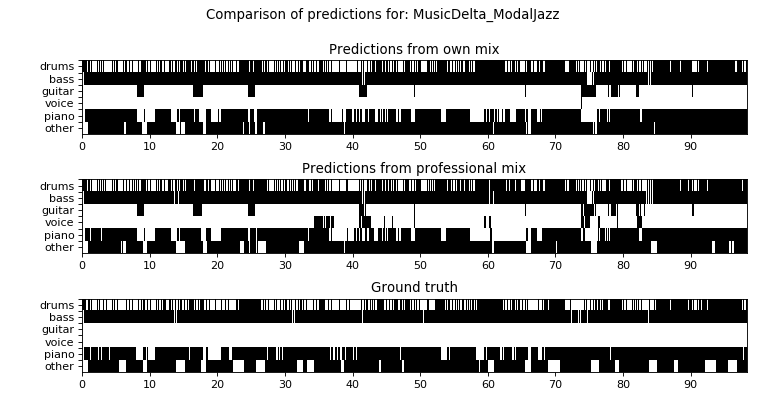

In [25]:
test_model_on_song()

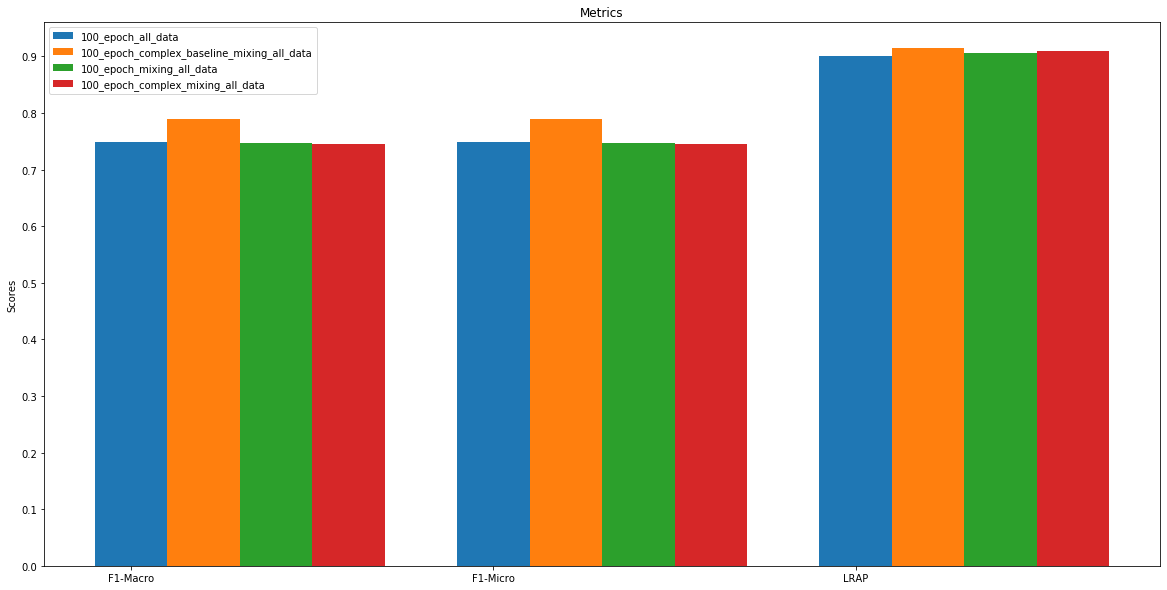

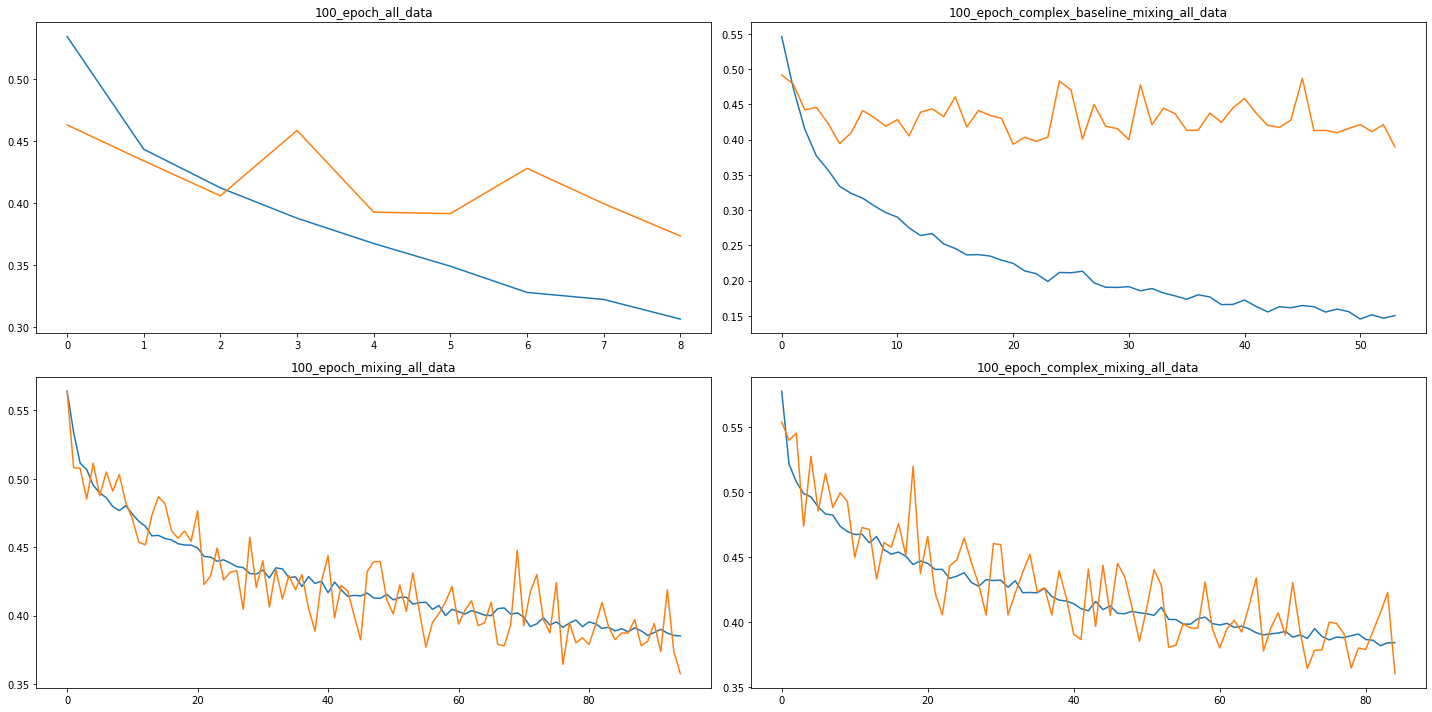

In [28]:
# state = {
#       "model_name": model_name,
#       "epoch": epoch + 1,
#       "lr": lr,
#       "train_losses": train_losses,
#       "validation_losses": validation_losses,
#       "state_dict": model.state_dict(),
#       "best_val_acc": validation_loss,
#       "optimizer": optimizer.state_dict(),
#       "metrics"
#   }

# https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger
#%matplotlib notebook
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams['figure.dpi'] = 200

models = [
    "100_epoch_baseline_all_data",
    "100_epoch_complex_baseline_all_data",
    "100_epoch_mixing_all_data",
    "100_epoch_complex_mixing_all_data",
]


def plot_training(models):
    fig = plt.figure()
    for i in range(len(models)):
        plt.subplot(2, 2, i + 1)
        plt.plot(models[i]["train_losses"])
        plt.plot(models[i]["validation_losses"])
        plt.title(models[i]["model_name"])

    plt.tight_layout()
    plt.show()


def plot_metrics(models):
    data = []
    model_names = []
    labels = ["F1-Macro", "F1-Micro", "LRAP"]

    for i in range(len(models)):
        model_data = []
        model_data.append(models[i]["metrics"]["macro avg"]["f1-score"])
        model_data.append(models[i]["metrics"]["macro avg"]["f1-score"])
        model_data.append(models[i]["metrics"]["lrap"])
        model_names.append(models[i]["model_name"])
        data.append(model_data)

    fig, ax = plt.subplots()
    X = np.arange(len(data[0]))
    for i in range(len(models)):
        width = (1 - 0.2) / len(models)
        ax.bar(X + width * i, data[i], width=width, label=model_names[i])

    plt.plot(data[0][0])
    ax.set_ylabel("Scores")
    ax.set_title("Metrics")
    x_ticks = []
    ax.set_xticks(X)
    ax.set_xticklabels(labels)
    ax.set_yticks(np.arange(0, 1, 0.1))
    ax.legend(loc="best")

    plt.show()


def compare_models(models):
    loaded_models = [load_state(m) for m in models]
    # print(loaded_models[0]['metrics']['macro avg'])
    plot_metrics(loaded_models)
    plot_training(loaded_models)


compare_models(models)